In [1]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm

def extract_features_from_loader(dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = models.resnet18(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])  # Remove classification layer
    model.to(device)
    model.eval()

    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Extracting features"):
            images = images.to(device)
            feats = model(images).squeeze(-1).squeeze(-1)  # (B, 2048)
            all_features.append(feats.cpu())
            all_labels.append(labels)

    features = torch.cat(all_features, dim=0).numpy()
    labels = torch.cat(all_labels, dim=0).numpy()
    return features, labels


In [2]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_clusters(features_2d, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', s=10)
    plt.title(title)
    plt.show()

def apply_and_plot_clustering(features, true_labels=None):
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    # KMeans
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans_labels = kmeans.fit_predict(features)
    plot_clusters(features_2d, kmeans_labels, "KMeans Clustering")

    # DBSCAN
    dbscan = DBSCAN(eps=5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(features)
    plot_clusters(features_2d, dbscan_labels, "DBSCAN Clustering")

    # Agglomerative
    agglo = AgglomerativeClustering(n_clusters=4)
    agglo_labels = agglo.fit_predict(features)
    plot_clusters(features_2d, agglo_labels, "Agglomerative Clustering")


Extracting features: 100%|██████████| 431/431 [27:35<00:00,  3.84s/it]


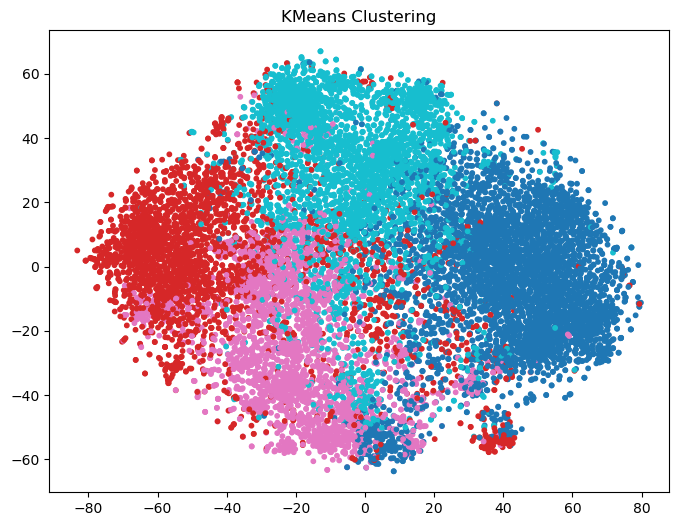

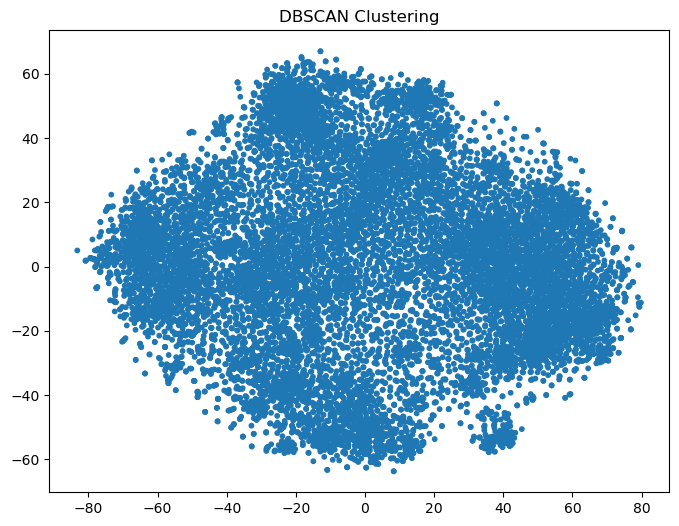

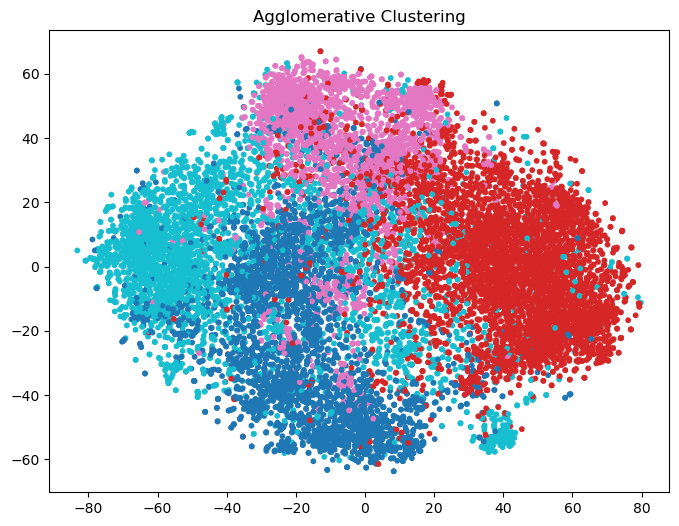

In [8]:
from art_clustering.data_loaders import WikiSubsetLoader

root_dir = '../../../data/wikiart_subset'
loader = WikiSubsetLoader(root_dir=root_dir, batch_size=32, normalize=True)
dataloader = loader.get_loader()

features, labels = extract_features_from_loader(dataloader, device='cpu')
apply_and_plot_clustering(features, true_labels=labels)

In [9]:
features

array([[1.271319  , 0.75437945, 1.538231  , ..., 2.1548285 , 0.3406668 ,
        0.04085997],
       [0.5817875 , 0.9781642 , 0.23306215, ..., 3.9580169 , 0.76318455,
        0.34371933],
       [0.9984499 , 0.6167881 , 1.5487688 , ..., 1.0644193 , 0.22552897,
        0.5190377 ],
       ...,
       [0.10912272, 1.0611883 , 1.2007635 , ..., 1.345736  , 0.9230677 ,
        0.40560532],
       [0.2664382 , 0.95267063, 0.44425583, ..., 2.5019057 , 0.5610748 ,
        1.2053456 ],
       [0.08625015, 1.5928233 , 0.8199664 , ..., 1.4259691 , 1.5824238 ,
        2.255613  ]], dtype=float32)

In [10]:
# Save features and labels to disk
import numpy as np
np.save('features.npy', features)
np.save('labels.npy', labels)